In [2]:
import pandas as pd
import numpy as np
import tqdm as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
import math
import joblib
from scipy import stats
from scipy.stats import randint, uniform
pd.set_option('display.max_column',None)

import plotly.express as px

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.compose import ColumnTransformer
import xgboost as xgb

import shap

# MERGE ASSESSOR and LISTINGS file together to fillna and get Lattiude/Longitude

In [16]:
cols = ['propertyid','apn','fips','situsstate','situscity','situszip5','situsfullstreetaddress','situsstreet','situsmode',
               'propertytype','lotsizesqft','homesize','style','heatingtype','coolingtype','storiesnbr','yearbuilt',
               'bedrooms','bathrooms','poolfeatures','pricepersqft',
               'interiorfeatures','exteriorfeatures','elementaryschool','middleschool','highschool','appliances',
               'facalculateddaysonmarket','currentlistingprice','minlistprice','maxlistprice','soldprice',
               'solddate'
               ]

path = 'D:\HORIZON\public_records_chicago_dallas_denver.sql\ds_listings.csv\ds_listings.csv'
ds_listings = pd.read_csv(path, usecols=cols)

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.


In [17]:
path = 'D:\HORIZON\public_records_chicago_dallas_denver.sql\ds_assessor_records.csv (a few)\ds_assessor_records.csv'

cols = ['propertyid','apn','situszip5','situsmode','poolcode',
            'situslatitude','situslongitude','lotsizesqft','buildingarea','sumlivingareasqft','currentsalesprice']

ds_assessor = pd.read_csv(path, usecols=cols)

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.


In [18]:
path = 'D:\HORIZON\public_records_chicago_dallas_denver.sql\ds_counties.csv ok\ds_counties.csv'

ds_counties = pd.read_csv(path)

In [19]:
ds_listings_combined = ds_listings
ds_listings_combined.shape

(1579256, 33)

In [20]:
ds_listings_combined = ds_listings.merge(ds_assessor, on='propertyid', how='left')

In [21]:
ds_listings_combined = ds_listings_combined.merge(ds_counties[['fips','county_name']], on='fips')

In [34]:
#Save csv file as new ds_listings file with better data
ds_listings_combined.to_csv('ds_listings_new.csv',index=False)

# BEGIN PROCESSING NEW FILE : DS_LISTINGS_NEW.CSV

In [116]:
path = 'D:\HORIZON\public_records_chicago_dallas_denver.sql\ds_listings_new.csv'
ds_listings = pd.read_csv(path)

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


In [117]:
ds_listings.sample(3)

,situsfullstreetaddress,situsstreet,situsmode_x,situscity,situsstate,situszip5_x,apn_x,fips,propertyid,propertytype,lotsizesqft_x,homesize,style,heatingtype,coolingtype,storiesnbr,yearbuilt,bedrooms,bathrooms,poolfeatures,pricepersqft,interiorfeatures,exteriorfeatures,elementaryschool,middleschool,highschool,appliances,facalculateddaysonmarket,currentlistingprice,maxlistprice,minlistprice,soldprice,solddate,apn_y,situsmode_y,situszip5_y,situslatitude,situslongitude,lotsizesqft_y,buildingarea,sumlivingareasqft,poolcode,currentsalesprice,county_name
322756,10104 Kilpatrick Ave,Kilpatrick,Ave,Oak Lawn,IL,60453.0,24-10-305-002,17031,44921600.0,DETACHED SINGLE,6098.0,2764.0,DETACHED,FORCED AIR,CENTRAL,NaN,1950.0,5.0,2.0,NaN,123.0,VAULTED/CATHEDRAL CEILINGS BAR-WET HARDWOOD FL...,NaN,J M HANNUM ELEMENTARY SCHOOL,OAK LAWN-HOMETOWN MIDDLE SCHOOL,H L RICHARDS HIGH SCH(CAMPUS),KITCHEN ON MAIN LEVEL,153.0,347900.0,347900.0,347900.0,341000.0,2020-03-11,24-10-305-002,AVE,60453.0,41.709137,-87.737755,6246.0,1382.0,1382.0,NaN,341000.0,Cook
1206190,10048 Isle Cir,Isle,Cir,Parker,CO,80134.0,2233-18-1-16-013,8035,152697831.0,RESIDENTIAL (NEC),6534.0,3984.0,NaN,FORCED AIR,CENTRAL,2.000000000000000,2015.0,6.0,5.0,NaN,163.0,"BEDROOM, FULL BATH, THREE-QUARTER BATH",CEMENT SIDING FRAME,PRAIRIE CROSSING,SIERRA,CHAPARRAL,"CONVECTION OVEN, COOKTOP, DISHWASHER, GARBAGE ...",180.0,649900.0,649900.0,649900.0,NaN,NaN,0486304,CIR,80134.0,39.534515,-104.820800,6621.0,4085.0,3984.0,NaN,640000.0,Douglas
207815,5407 S Xenon St,Xenon,St,Littleton,CO,80127.0,59-172-09-005,8059,23984727.0,RESIDENTIAL (NEC),246671568.0,1433.0,HOUSE,FORCEDAIR,CENTRAL,3.000000000000000,1993.0,3.0,2.0,NaN,447.0,"EAT-IN KITCHEN, MASTER BATH",NaN,MOUNT CARBON,SUMMIT RIDGE,DAKOTA RIDGE,COOKTOP DISHWASHER,24.0,550000.0,550000.0,550000.0,640000.0,2022-02-18,59-172-09-005,ST,80127.0,39.618740,-105.141815,5489.0,2262.0,1433.0,NaN,640000.0,Jefferson


In [118]:
#Drop the apn_x & apn_y (just for making sure the merge is correct on same propertyID)
#Drop full streed address because we don't need it
ds_listings = ds_listings.drop(columns=['apn_x','apn_y','situsfullstreetaddress'])

In [109]:
ds_listings = ds_listings.drop_duplicates()

In [119]:
ds_listings.isna().sum()

situsstreet                    1337
situsmode_x                   40198
situscity                       473
situsstate                      401
situszip5_x                    2559
fips                              0
propertyid                    90135
propertytype                  14874
lotsizesqft_x                556921
homesize                     250232
style                        408557
heatingtype                  170879
coolingtype                  277206
storiesnbr                   336883
yearbuilt                    154399
bedrooms                     114650
bathrooms                    137743
poolfeatures                1198690
pricepersqft                 252957
interiorfeatures             377767
exteriorfeatures             952533
elementaryschool             309176
middleschool                 359171
highschool                   280275
appliances                   292877
facalculateddaysonmarket      19235
currentlistingprice           16143
maxlistprice                

In [120]:
#Fill sold price by 1st priority [current sale price] of assessor then [current listings price]
ds_listings.loc[ds_listings['soldprice'].isnull(), 'soldprice'] = ds_listings['currentsalesprice']
ds_listings.loc[ds_listings['soldprice'].isnull(), 'soldprice'] = ds_listings['currentlistingprice']

#Fillna zipcode with the value from assesor:
ds_listings.loc[ds_listings['situszip5_x'].isnull(), 'situszip5_x'] = ds_listings['situszip5_y']

#Fillna lotsizesqft_x with the value from y
ds_listings.loc[ds_listings['lotsizesqft_x'].isnull(), 'lotsizesqft_x'] = ds_listings['lotsizesqft_y']

#Fillna homesize with the value from y: building area  
ds_listings.loc[ds_listings['homesize'].isnull(), 'homesize'] = ds_listings['buildingarea']

#Fillna situsmode_x with the value from y
ds_listings.loc[ds_listings['situsmode_x'].isnull(), 'situsmode_x'] = ds_listings['situsmode_y']

#Fillna poolfeatures with pool code from assessor
ds_listings.loc[ds_listings['poolfeatures'].isnull(),'poolfeatuers'] = ds_listings['poolcode']


In [121]:
#After fillna with value from assesor:
ds_listings.isna().sum()

situsstreet                    1337
situsmode_x                   36486
situscity                       473
situsstate                      401
situszip5_x                    1263
fips                              0
propertyid                    90135
propertytype                  14874
lotsizesqft_x                 39081
homesize                      31854
style                        408557
heatingtype                  170879
coolingtype                  277206
storiesnbr                   336883
yearbuilt                    154399
bedrooms                     114650
bathrooms                    137743
poolfeatures                1198690
pricepersqft                 252957
interiorfeatures             377767
exteriorfeatures             952533
elementaryschool             309176
middleschool                 359171
highschool                   280275
appliances                   292877
facalculateddaysonmarket      19235
currentlistingprice           16143
maxlistprice                

In [123]:
#Drop Nan data in these column because we cannot impute or guess
#features drop will cut down a lot of data:
# Solddate: 660k
# Storiesnbr: 335k
# Lotsizesqft: 39k
# Homesize : 31k
# Bedroom/Bathroom: 110k

ds_listings_nonan = ds_listings.dropna(subset=['soldprice','solddate','situscity','situsstate','situszip5_x','storiesnbr',
                                         'lotsizesqft_x','situslatitude','situslongitude','bedrooms','bathrooms',
                                          'facalculateddaysonmarket'])


In [146]:
ds_listings_nonan= ds_listings_nonan.rename(columns={'lotsizesqft_x':'lotsizesqft', 'situsmode_x':'situsmode','situszip5_x':'situszip5'})
ds_listings_nonan = ds_listings_nonan.drop(columns=['lotsizesqft_y','situsmode_y','situszip5_y'])

In [149]:
ds_listings_nonan.shape

(726446, 41)

In [150]:
ds_listings_nonan['solddate'] = pd.to_datetime(ds_listings_nonan['solddate'])

In [151]:
#Fillna to poolfeatures and style
ds_listings_nonan['poolfeatures'] = ds_listings_nonan['poolfeatures'].fillna('unknown')
ds_listings_nonan['style'] = ds_listings_nonan['style'].fillna('other')

# PRE-PROCESSING

In [152]:
ds_listings_nonan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726446 entries, 33 to 1579221
Data columns (total 41 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   situsstreet               726038 non-null  object        
 1   situsmode                 717506 non-null  object        
 2   situscity                 726446 non-null  object        
 3   situsstate                726446 non-null  object        
 4   situszip5                 726446 non-null  object        
 5   fips                      726446 non-null  int64         
 6   propertyid                726446 non-null  float64       
 7   propertytype              725462 non-null  object        
 8   lotsizesqft               726446 non-null  float64       
 9   homesize                  726438 non-null  float64       
 10  style                     726446 non-null  object        
 11  heatingtype               716239 non-null  object        
 12  

In [153]:
#Use the above code for property type

# def propertytype_processing(value):
#   if value and isinstance(value, str):
#     value = value.lower()
#     value = " ".join(value.split())
    
#     property_dict = {'sfr':['SFR','RESIDENTIAL (NEC)','DETACHED SINGLE','DETACHED SINGLE, SFR',
#                     'RES-SINGLE FAMILY','RESIDENTIAL (NEC), SFR','SINGLEFAMILYRESIDENCE',
#                     'HOUSE','RES-SINGLE FAMILY, SFR','SFR, SINGLEFAMILYRESIDENCE',
#                     'LND','LND-RESIDENTIAL','HOUSE, SFR','DETACHED SINGLE FAMILY - 2 STORIES',
#                     'DETACHED SINGLE, RESIDENTIAL (NEC), SFR','1 STORY, SFR',
#                     'RESIDENTIAL (NEC)','RESIDENTIAL LOT',
#                     '2 STORIES, SFR','DETACHED SINGLE FAMILY - 1 STORY', '2 STORY, SFR',
#                     'DUPLEX','SINGLE_FAMILY','SINGLE FAMILY DETACH','MIXED USE',
#                     'RESIDENTIAL (NEC), SFR, SINGLEFAMILYRESIDENCE'
#                     'ATTACHED SINGLE','RES','RESIDENTIAL (NEC), RES-SINGLE FAMILY, SFR'
#                     ],

#                     'vacant land': ['VACANT LAND (NEC)','VACANT LAND / LOTS','Vacant (NEC)',
#                       'FARMS','FARM / RANCH','INDUSTRIAL','LOT / LAND','VACANT LAND (NEC)', 
#                       'VACANT LAND / LOTS','SFR, VACANT LAND (NEC)','OTHER RESIDENTIAL',
#                       'VACANT LAND (NEC), VACANT LAND / LOTS',
#                     ],

#                     'multi family': ['MULTI FAMILY DWELLING','MULTI FAMILY 5+','MULTI-FAMILY (2-4 UNITS)',
#                       'MULTIPLE UNIT (2-4)' 
#                     ],

#                     'condominium': ['CONDOMINIUM','RES-CONDO',
#                       'CONDOMINIUM, SFR','CONDOMINIUM, RESIDENTIAL (NEC)'
#                     ],

#                     'town house' : ['TOWNHOUSE/ROWHOUSE','COMMERCIAL (NEC)','VILLA/TOWNHOUSE',
#                       'COMMERCIAL SALE','RES-TOWNHOUSE','BUSINESS OPPORTUNITY','SALE',
#                       'LND-COMMERCIAL','COM-SALE'
#                     ],
                    
#                     'large land house': ['LOTS & ACREAGE','MANUFACTURED HOME','ACREAGE']
#                     }
      
#     if value not in property_dict.keys():
#         for k, v in property_dict.items():
#             if value in [x.lower() for x in v]:
#                 value = k
#                 break
#         else:
#             value = 'other'

#   return value 

In [154]:
def get_stories_with_comma(value):
    if ',' in value:
        value = value.split(',')[1]
    
    return value

def convert_to_float(value):
    try:
        return float(value)
    except:
        return value

ds_listings_nonan.loc[:, 'storiesnbr_processed'] = ds_listings_nonan['storiesnbr'].apply(get_stories_with_comma)
ds_listings_nonan.loc[:, 'storiesnbr_processed'] = ds_listings_nonan['storiesnbr_processed'].apply(convert_to_float)

In [155]:
pattern = re.compile(r'[^.\d]+')  #Find all the text pattern

# use the str.contains() method to filter the column to only include matching instances
matching_instances = ds_listings_nonan[ds_listings_nonan['storiesnbr_processed'].astype(str).str.contains(pattern)]
matching_instances['storiesnbr_processed'].value_counts()

NONE                      729
2 STRY W/BSMT             562
1 STRY W/BSMT             222
1  1/2                     88
2 STRY W/ ATTIC & BSMT     86
1 STRY W/ ATTIC & BSMT     80
 NONE                      30
SPLIT 3 LEVEL W/ BSMT      27
3 STRY W/BSMT              26
 2 STRY W/BSMT             12
3 STRY W/ ATTIC & BSMT     11
SPLIT 3 LEVEL               9
ONE AND HALF STORY          6
 1 STRY W/BSMT              6
6 STORY WITH BASEMENT       1
2 STRY W/ ATTIC             1
Name: storiesnbr_processed, dtype: int64

In [156]:
def storiesnbr_processing(value):
  stories_dict = {
    0.0: ['NONE',' NONE'],
    1.0: ['1 STRY W/BSMT','1 STRY W/ ATTIC & BSMT',' 1 STRY W/BSMT'],
    1.5: ['1  1/2','ONE AND HALF STORY'],
    2.0: ['2 STRY W/BSMT','2 STRY W/ ATTIC & BSMT',' 2 STRY W/BSMT','2 STRY W/ ATTIC'],    
    3.0: ['SPLIT 3 LEVEL W/ BSMT','3 STRY W/BSMT','3 STRY W/ ATTIC & BSMT','SPLIT 3 LEVEL'],
    6.0: ['6 STORY WITH BASEMENT']
    }

  for k,v in stories_dict.items():
    if value in v:
      return k  
    
  return value

ds_listings_nonan['storiesnbr_processed'] = ds_listings_nonan['storiesnbr_processed'].apply(storiesnbr_processing)

In [157]:
def storiesnbr_processing_condo(value):
    if value >8:
        return 0.0
    else:
        return value

ds_listings_nonan['storiesnbr_processed'] = ds_listings_nonan['storiesnbr_processed'].apply(storiesnbr_processing_condo)

In [158]:
def propertytype_processing(value):
    if 'townhouse' in str(value).lower():           #Town house
        value = 'town house'
    elif 'rowhouse' in str(value).lower():
        value = 'town house'


    elif 'condominum' in str(value).lower():          #Condominuum part
        value = 'condominum'
    elif 'condo' in str(value).lower():
        value = 'condominum'


    elif 'multi' in str(value).lower():           #Multi family
        value = 'multi family'


    elif 'vacant' in str(value).lower():            #large land
        value = 'vacant land'
    elif 'land' in str(value).lower():
        value = 'vacant land'
    elif 'lot' in str(value).lower():
        value = 'vacant land'
    elif 'farm' in str(value).lower():
        value = 'vacant land'
    elif 'manufact' in str(value).lower():
        value = 'vacant land'


    elif 'sfr' in str(value).lower():             #SFR family
        value = 'sfr'    
    elif 'single' in str(value).lower():
        value = 'sfr'
    elif 'res' in str(value).lower():
        value = 'sfr'
    elif 'house' in str(value).lower():
        value = 'sfr'   
    
    else:
        value = 'sfr'

    return value

In [159]:
def streetmode_processing(value):
    value = str(value)
    value = value.lower()

    street_dict ={'private drive': ['Dr','Ct','Pl','Sq','Mdws','Walk'],

                'general street': ['St','Rd','Ct','Way','Cir','Loop','Run','Rdg','Xing','Bnd','Mews',
                                    'Cres','Crse','Mls','Spur','Rnch','Pr','Br'],

                'ave': ['Ave','Blvd','Row','Plz','Mnr','Clb','Mall'],

                'lane': ['Ln','Pkwy','Hwy','Ln','Fwy','Expy',],

                'trail': ['Trl','Ter','Cv','Pass','Pt','Park','Path','Vw','Trce','Vis','Crk','Hl','Vly',
                        'Holw','Gln','Grv','Lndg','Blf','Mtn','Grn','Hls','Gdns','Mdw','Cyn','Spgs','Lk']
               }
  
    for k, v_list in street_dict.items():
        for v in v_list:
            if value == v.lower():
                value = k
                break
        else:
            continue
        break
    else:
        value = 'general street'
    
    return value

In [160]:
def poolfeature_processing(value):
    value = str(value)
    pool_dict ={
        'no':['NO','no','NONE','COMMUNITY POOL, NO','PRIVATE Y/N NO'],
        'private' : ['YES','IN GROUND GUNITE','ABOVE GROUND','POOL IN-GROUND','POOL',
                     'TENNIS COURT(S)','CLEANING SYSTEM, IN GROUND GUNITE', 
                    'SEPARATE SPA/HOT TUB','ATTACHED SPA, IN GROUND GUNITE','TRAIL(S)',
                    'ATTACHED SPA, CLEANING SYSTEM, HEATED, IN GROUND GUNITE, WATER FEATURE',
                    'PRIVATE','INDOOR','ATTACHED SPA','DIVING, IN GROUND GUNITE',
                    'IN GROUND GUNITE, WATER FEATURE','ATTACHED SPA, CLEANING SYSTEM, HEATED, IN GROUND GUNITE',
                    'IN GROUND','ATTACHED SPA, CLEANING SYSTEM, IN GROUND GUNITE','CLEANING SYSTEM, IN GROUND GUNITE, WATER FEATURE',
                    'ATTACHED SPA, HEATED, IN GROUND GUNITE','CLEANING SYSTEM IN GROUND GUNITE','IN GROUND GUNITE, PLAY POOL',
                    'IN GROUND GUNITE, POOL PERIMETER FENCE','CLEANING SYSTEM, DIVING, IN GROUND GUNITE',
                    'IN GROUND FIBERGLASS','IN GROUND GUNITE, SEPARATE SPA/HOT TUB','POOLSPACOMBO',
                    'IN GROUND GUNITE, POOL PERIMETER FENCE','CLEANING SYSTEM, DIVING, IN GROUND GUNITE',
                    'IN GROUND FIBERGLASS','IN GROUND GUNITE, SEPARATE SPA/HOT TUB','CLEANING SYSTEM, IN GROUND GUNITE, PLAY POOL',
                    'GUNITE, IN GROUND','HEATED, IN GROUND GUNITE','ATTACHED SPA, HEATED, IN GROUND GUNITE, WATER FEATURE',
                    'OUTDOORPOOL, PRIVATE','WATER FEATURE','DIVING'
                      ],
        'community': ['ASSOCIATION','COMMUNITY POOL','OUTDOORPOOL',
                    'TENNIS COURT(S), TRAIL(S)','OUTDOOR POOL','ASSOCIATION, OUTDOORPOOL',
                    'OUTDOOR POOL ASSOCIATION','SPA/HOT TUB, TENNIS COURT(S), TRAIL(S)','POOLSPACOMBO',
                    'ASSOCIATION, OUTDOOR POOL','OUTDOOR POOL, OUTDOORPOOL','RESIDENTIAL'
                     ],
        'other': ['OTHER','TRAIL(S)','MOUNTAIN','RES','PDU','CLEANING SYSTEM','PUD',
                  'RPD'
                     ],
        'unknown': 'unknown'
    }
    for k,v in pool_dict.items():
        if value in v:
            value = k
            break
    else:
        value = 'other'
    
    return value

In [161]:
def style_processing(value):
    if 'bungalow' in str(value).lower():           #Bungalow
        value = 'bungalow'

    elif 'colonial' in str(value).lower():
        value = 'high luxury'
    elif 'victorian' in str(value).lower():
        value = 'high luxury'
    elif 'english' in str(value).lower():
        value = 'high luxury'
    elif 'georgian' in str(value).lower():
        value = 'high luxury'
    elif 'tudor' in str(value).lower():
        value = 'high luxury'
    elif 'queen' in str(value).lower():
        value = 'high luxury'
    elif 'french' in str(value).lower():
        value = 'high luxury'
    elif 'prairie' in str(value).lower():
        value = 'high luxury'    
    elif 'medit' in str(value).lower():
        value = 'high luxury'
    elif 'cape' in str(value).lower():
        value = 'high luxury'         
 

    elif 'ranch' in str(value).lower():         #Ranch
        value = 'ranch'
    elif 'farm' in str(value).lower():
        value = 'ranch'


    elif 'modern' in str(value).lower():        #modern
        value = 'modern'
    elif 'contemporary' in str(value).lower():
        value = 'modern'  
    elif 'new' in str(value).lower():
        value = 'modern' 
    elif 'contemporary' in str(value).lower():
        value = 'modern'  
    elif 'duplex' in str(value).lower():
        value = 'modern'  
    elif 'triplex' in str(value).lower():
        value = 'modern' 
    elif 'craft' in str(value).lower():
        value = 'modern'  
    elif 'rise' in str(value).lower():
        value = 'modern'  
    elif 'flat' in str(value).lower():
        value = 'modern'  
        

    elif 'traditional' in str(value).lower():            #traditional
        value = 'traditional'    
    elif 'level' in str(value).lower():
        value = 'traditional'
    elif 'american' in str(value).lower():
        value = 'traditional'
    elif 'condo' in str(value).lower():
        value = 'traditional'
    elif 'attached' in str(value).lower():
        value = 'traditional'
    elif 'detached' in str(value).lower():
        value = 'traditional'
    elif 'stor' in str(value).lower():
        value = 'traditional'    
    elif '-' in str(value).lower():
        value = 'traditional'
    elif 'house' in str(value).lower():
        value = 'traditional'
    elif 'frame' in str(value).lower():
        value = 'traditional'
    elif 'family' in str(value).lower():
        value = 'traditional'
    elif '0' in str(value).lower():
        value = 'traditional'        

    else:
        value = 'other'

    return value

In [162]:
# def style_processing(value):
#     value = str(value)
#     style_dict ={
#         'traditional':['TRADITIONAL','BI-LEVEL','-','SINGLE-LEVEL','HOUSE','AMERICAN 4-SQ.','DUPLEX',
#                         'HOUSE, TRADITIONAL','LOW RISE'],
#         'modern' : ['CONTEMPORARY','NEW TRADITIONAL','CONTEMPORARY/MODERN',
#                      'NEW TRADITIONAL, TRADITIONAL','MID-CENTURY MODERN','CONTEMPORARY/MODERN, TRADITIONAL',
#                      'CONTEMPORARY, HOUSE' ,'BI-LEVEL, CONTEMPORARY'
#                       ],
#         'ranch': ['RANCH','STEP RANCH','FARM HOUSE','RANCH, SINGLE-LEVEL','RANCH, TRADITIONAL','WALK-OUT RANCH',
#                     'RAISED RANCH','RANCH/1 STORY'
#                      ],
#         'detached': ['SINGLE DETACHED','DETACHED','SINGLE DETACHED, TRADITIONAL'
#                      ],
#         'split level': ['BI-LEVEL','TRI-LEVEL','1-1/2 STORY','1 1/2 STORY','SPLIT LEVEL','TOWNHOUSE',
#                         'QUAD LEVEL','CRAFTSMAN','3+ STORY','5+ STORY','BI-LEVEL, TRADITIONAL',
#                         'CONDO/TOWNHOME'],
#         'victorian' : ['GEORGIAN','TUDOR','VICTORIAN','ENGLISH','QUEEN ANNE'],
#         'colonial'  : ['COLONIAL','CAPE COD','PRAIRIE','FRENCH PROVINCIAL','FRENCH'],
#         'bungalow'   :['BUNGALOW','COTTAGE/BUNGALOW','RANCH/1 STY/BUNGALOW']
                   
#     }
#     for k,v in style_dict.items():
#         if value in v:
#             value = k
#             break
#     else:
#         value = 'other'
    
#     return value

In [163]:
def zoning_processing(value):
    value = str(value)
    pool_dict ={
        'residential':['RESIDENTIAL','SFR','RDP','RPD'],
        'pud' : ['PDU','PUD','P-D','PD'],
    
        'commercial': ['COMMERCIAL','STEP RANCH','FARM HOUSE','RANCH, SINGLE-LEVEL','RANCH, TRADITIONAL','WALK-OUT RANCH',
                    'RAISED RANCH','RANCH/1 STORY'
                     ],
        'condominum': ['AMU','CONDOMINIUM','SINGLE DETACHED, TRADITIONAL'
                     ],
        'rural': ['RR']

                   
    }
    for k,v in pool_dict.items():
        if value in v:
            value = k
            break
    else:
        value = 'residential'
    
    return value

In [164]:
def yearbuilt_processed(df,yearbuilt_col):
    df[yearbuilt_col] = df[yearbuilt_col].fillna(df[yearbuilt_col].median())

    now = datetime.datetime.now().year
    df['age'] = now - df[yearbuilt_col]
    df['age'] = df['age'].round()
    return df


In [165]:
def solddate_processed(df,solddate_col):
    df['soldyear'] = df[solddate_col].dt.year
    df['soldyeartillnow'] = 2023 - df['soldyear']
    df['soldmonth'] = df[solddate_col].dt.month
    df['soldday'] = df[solddate_col].dt.day
    
    return df['soldyear'],df['soldyeartillnow'],df['soldmonth'],df['soldday']

In [166]:
ds_listings_nonan['propertytype_processed'] = ds_listings_nonan['propertytype'].apply(propertytype_processing)
ds_listings_nonan['situsmode_processed'] = ds_listings_nonan['situsmode'].apply(streetmode_processing)

ds_listings_nonan['poolfeatures_processed'] = ds_listings_nonan['poolfeatures'].apply(poolfeature_processing)
ds_listings_nonan['style_processed'] = ds_listings_nonan['style'].apply(style_processing)

solddate_processed(ds_listings_nonan,'solddate')

(33         2018
 55         2020
 188        2020
 203        2020
 216        2017
            ... 
 1579172    2021
 1579183    2022
 1579192    2022
 1579197    2022
 1579221    2021
 Name: soldyear, Length: 726446, dtype: int64,
 33         5
 55         3
 188        3
 203        3
 216        6
           ..
 1579172    2
 1579183    1
 1579192    1
 1579197    1
 1579221    2
 Name: soldyeartillnow, Length: 726446, dtype: int64,
 33          1
 55         10
 188         9
 203        10
 216         6
            ..
 1579172     3
 1579183     8
 1579192     8
 1579197     7
 1579221     7
 Name: soldmonth, Length: 726446, dtype: int64,
 33         16
 55         15
 188        26
 203        14
 216        14
            ..
 1579172     3
 1579183    12
 1579192     1
 1579197    29
 1579221    30
 Name: soldday, Length: 726446, dtype: int64)

There are two steps here I will do one by one:
1. Remove outliers
2. Fillna. Different Type of House give different range of home size. We should fillna of home size by using the medium size for each of the property type

In [171]:
ds_listings_nonan[['lotsizesqft','homesize','soldprice','bedrooms','bathrooms']].describe()


,lotsizesqft,homesize,soldprice,bedrooms,bathrooms
count,6.442640e+05,6.442640e+05,6.442640e+05,644264.000000,644264.000000
mean,6.931124e+07,2.358251e+03,1.024825e+06,3.313454,2.381311
std,9.903154e+08,8.327572e+04,2.150036e+07,1.332976,1.359064
min,1.001000e+03,3.120000e+02,3.010000e+04,1.000000,0.500000
25%,6.098000e+03,1.350000e+03,2.280000e+05,3.000000,2.000000
50%,9.148000e+03,1.876000e+03,3.350000e+05,3.000000,2.000000
75%,2.308700e+04,2.646000e+03,5.000000e+05,4.000000,3.000000
max,1.667310e+11,6.573204e+07,1.191013e+09,400.000000,314.000000


lotsizesqft <1000 seems impossible hence outliers
homesize <300 is considered outliers
sold price <50,000usd is also considered outliers

In [172]:
#sold price research more minimum sold price
ds_listings_nonan = ds_listings_nonan[ds_listings_nonan['lotsizesqft']>1000]
ds_listings_nonan = ds_listings_nonan[ds_listings_nonan['homesize']>300]
ds_listings_nonan = ds_listings_nonan[ds_listings_nonan['soldprice']>30000]

In [173]:
ds_listings_nonan.shape

(644264, 48)

In [174]:
def remove_outliers(df,col,method):
    if method == 'IQR':
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        threshold = 1.5 * IQR

        outliers_mask = (df[col] < Q1 - threshold) | (df[col] > Q3 + threshold*1.5) #upperbound gets wider

        df1 = df.drop(df[outliers_mask].index)
        return df1

    else:

        mean = df[col].mean()
        std = df[col].std()
        
        lower_bound = mean - 2*std
        upper_bound = mean + 2*std

        outliers_mask = (df[col] < lower_bound ) | (df[col] > upper_bound)
        df1 = df.drop(df[outliers_mask].index)

        return df1

In [ ]:
px.histogram(ds_listings_nonan,x='soldprice',marginal='box')

In [ ]:
px.histogram(np.log1p(ds_listings_nonan['soldprice']),marginal='box')

Soldprice get bell curved when using Log(soldprice). So we will remove outliers of sold price outside Upper fence and Lower Fence

In [175]:
ds_listings_nonan['log1psoldprice'] = np.log1p(ds_listings_nonan['soldprice'])   
ds_listings_nonan = ds_listings_nonan.loc[(ds_listings_nonan['log1psoldprice'] >=11.1) & (ds_listings_nonan['log1psoldprice'] <= 14.3)]

In [ ]:
px.histogram(np.log1p(ds_listings_nonan['lotsizesqft']),marginal='box')

In [176]:
ds_listings_nonan['log1plotsizesqft'] = np.log1p(ds_listings_nonan['lotsizesqft'])   
ds_listings_nonan = ds_listings_nonan.loc[(ds_listings_nonan['log1plotsizesqft'] >=7) & (ds_listings_nonan['log1plotsizesqft'] <= 12.2)]

In [ ]:
px.histogram(np.log1p(ds_listings_nonan['homesize']),marginal='box')

In [177]:
ds_listings_nonan['log1phomesize'] = np.log1p(ds_listings_nonan['homesize'])   
ds_listings_nonan = ds_listings_nonan.loc[(ds_listings_nonan['log1phomesize'] >=6.24) & (ds_listings_nonan['log1phomesize'] <= 8.85)]

In [ ]:
px.histogram(ds_listings_nonan['bathrooms'],marginal='box')

In [178]:
ds_listings_nonan = ds_listings_nonan.loc[(ds_listings_nonan['bathrooms'] >=1) & (ds_listings_nonan['bathrooms'] <= 8)]
ds_listings_nonan = ds_listings_nonan.loc[(ds_listings_nonan['bedrooms'] >=1) & (ds_listings_nonan['bedrooms'] <= 8)]

In [ ]:
px.histogram(np.log1p(ds_listings_nonan['facalculateddaysonmarket']),marginal='box')

In [179]:
ds_listings_nonan['log1pfacalculateddaysonmarket'] = np.log1p(ds_listings_nonan['facalculateddaysonmarket'])   
ds_listings_nonan = ds_listings_nonan.loc[(ds_listings_nonan['log1pfacalculateddaysonmarket'] >=2.197) & (ds_listings_nonan['log1pfacalculateddaysonmarket'] <= 6.01)]

In [180]:
ds_listings_nonan[['lotsizesqft','homesize','soldprice','bedrooms','bathrooms','facalculateddaysonmarket','soldyeartillnow']].describe()

,lotsizesqft,homesize,soldprice,bedrooms,bathrooms,facalculateddaysonmarket,soldyeartillnow
count,530120.000000,530120.000000,5.301200e+05,530120.000000,530120.000000,530120.000000,530120.000000
mean,15146.656312,2093.578997,3.819116e+05,3.304225,2.330649,78.189044,2.713435
std,23344.165912,983.576518,2.241648e+05,0.996217,0.943656,67.757317,1.153051
min,1096.000000,512.000000,6.625000e+04,1.000000,1.000000,8.000000,1.000000
25%,5663.000000,1361.000000,2.300000e+05,3.000000,2.000000,36.000000,2.000000
50%,8276.000000,1872.000000,3.275000e+05,3.000000,2.000000,53.000000,2.000000
75%,12632.000000,2600.000000,4.750000e+05,4.000000,3.000000,93.000000,3.000000
max,198677.000000,6972.000000,1.623000e+06,8.000000,8.000000,406.000000,11.000000


In [144]:
# ds_listings_nonan = remove_outliers(df=ds_listings_nonan, col='homesize',method='IQR')
# ds_listings_nonan = remove_outliers(df=ds_listings_nonan, col='bathrooms',method='IQR')
# ds_listings_nonan = remove_outliers(df=ds_listings_nonan, col='bedrooms',method='IQR')
# ds_listings_nonan = remove_outliers(df=ds_listings_nonan, col='lotsizesqft',method='IQR')

# ds_listings_nonan = remove_outliers(df=ds_listings_nonan, col='soldprice',method ='IQR')
# ds_listings_nonan = remove_outliers(df=ds_listings_nonan, col='facalculateddaysonmarket',method='IQR')

In [181]:
ds_listings_nonan = yearbuilt_processed(ds_listings_nonan,'yearbuilt')

In [95]:
# ds_listings_nonan['elementaryschool'] = ds_listings_nonan['elementaryschool'].apply(lambda x: 0 if pd.isna(x) else 1)
# ds_listings_nonan['middleschool'] = ds_listings_nonan['middleschool'].apply(lambda x: 0 if pd.isna(x) else 1)
# ds_listings_nonan['highschool'] = ds_listings_nonan['highschool'].apply(lambda x: 0 if pd.isna(x) else 1)


In [182]:
#Drop 'other' value from columns to make this dataset as cleaned as possible 
ds_listings_nonan = ds_listings_nonan[ds_listings_nonan['propertytype_processed'] != 'other']
ds_listings_nonan = ds_listings_nonan[ds_listings_nonan['poolfeatures_processed'] != 'other']


In [183]:
ds_listings_nonan.describe()

,fips,propertyid,lotsizesqft,homesize,yearbuilt,bedrooms,bathrooms,pricepersqft,facalculateddaysonmarket,currentlistingprice,maxlistprice,minlistprice,soldprice,situslatitude,situslongitude,buildingarea,sumlivingareasqft,poolcode,currentsalesprice,poolfeatuers,storiesnbr_processed,soldyear,soldyeartillnow,soldmonth,soldday,log1psoldprice,log1plotsizesqft,log1phomesize,log1pfacalculateddaysonmarket,age
count,513848.000000,5.138480e+05,513848.000000,513848.000000,513848.000000,513848.000000,513848.000000,490737.000000,513848.000000,5.136870e+05,5.072320e+05,5.064810e+05,5.138480e+05,513848.000000,513848.000000,513595.000000,447676.000000,17286.000000,5.117040e+05,5685.000000,513848.000000,513848.000000,513848.000000,513848.000000,513848.000000,513848.000000,513848.000000,513848.000000,513848.000000,513848.000000
mean,24201.212070,7.047557e+07,14970.799507,2067.675307,1979.193495,3.293192,2.313853,187.992350,78.617605,3.776566e+05,3.792908e+05,3.770544e+05,3.769109e+05,39.249075,-92.629719,1803.250283,2009.867252,7.237475,5.794306e+05,6.652419,1.681635,2020.275309,2.724691,6.906404,16.286472,12.692066,9.109907,7.535315,4.111899,43.806505
std,14958.605662,4.573226e+07,23150.467326,963.024246,30.409480,0.992267,0.935524,83.155785,68.033335,2.282725e+05,2.293819e+05,2.280986e+05,2.207381e+05,3.895929,6.461086,1427.216882,950.851588,2.395712,1.240001e+07,3.164813,0.911761,1.157769,1.157769,3.294223,8.841017,0.542706,0.885888,0.444080,0.695516,30.409480
min,8001.000000,2.229870e+07,1096.000000,512.000000,1800.000000,1.000000,1.000000,1.000000,8.000000,1.400000e+03,1.400000e+03,2.000000e+00,6.625000e+04,0.000000,-106.088980,0.000000,120.000000,1.000000,0.000000e+00,1.000000,0.000000,2012.000000,1.000000,1.000000,1.000000,11.101206,7.000334,6.240276,2.197225,1.000000
25%,17031.000000,4.418288e+07,5663.000000,1350.000000,1959.000000,3.000000,2.000000,133.000000,36.000000,2.289000e+05,2.295000e+05,2.269000e+05,2.271010e+05,33.258271,-97.008713,1138.000000,1321.000000,8.000000,2.289000e+05,8.000000,1.000000,2020.000000,2.000000,4.000000,9.000000,12.333155,8.641886,7.208600,3.610918,20.000000
50%,17043.000000,4.626485e+07,8276.000000,1850.000000,1986.000000,3.000000,2.000000,169.000000,53.000000,3.240000e+05,3.249000e+05,3.200000e+05,3.245200e+05,41.634743,-88.234563,1686.000000,1810.000000,8.000000,3.279000e+05,8.000000,2.000000,2021.000000,2.000000,7.000000,16.000000,12.690106,9.021236,7.523481,3.988984,37.000000
75%,48085.000000,1.278327e+08,12197.000000,2562.000000,2003.000000,4.000000,3.000000,223.000000,94.000000,4.599990e+05,4.630000e+05,4.599000e+05,4.665000e+05,41.939360,-87.840160,2413.000000,2489.000000,8.000000,4.770000e+05,9.000000,2.000000,2021.000000,3.000000,10.000000,24.000000,13.053015,9.409027,7.848934,4.553877,64.000000
max,55059.000000,1.704242e+08,198677.000000,6972.000000,2022.000000,8.000000,8.000000,1944.000000,406.000000,9.500000e+06,9.500000e+06,9.500000e+06,1.623000e+06,42.668217,0.000000,506930.000000,90000.000000,12.000000,1.267238e+09,12.000000,8.000000,2022.000000,11.000000,12.000000,31.000000,14.299787,12.199441,8.849801,6.008813,223.000000


In [184]:
ds_listings_nonan.shape

(513848, 53)

***NOW WE MOVE ON TO THE DF FOR MODELING

In [185]:
ds_listings_nonan.sample(3)

,situsstreet,situsmode,situscity,situsstate,situszip5,fips,propertyid,propertytype,lotsizesqft,homesize,style,heatingtype,coolingtype,storiesnbr,yearbuilt,bedrooms,bathrooms,poolfeatures,pricepersqft,interiorfeatures,exteriorfeatures,elementaryschool,middleschool,highschool,appliances,facalculateddaysonmarket,currentlistingprice,maxlistprice,minlistprice,soldprice,solddate,situslatitude,situslongitude,buildingarea,sumlivingareasqft,poolcode,currentsalesprice,county_name,poolfeatuers,storiesnbr_processed,propertytype_processed,situsmode_processed,poolfeatures_processed,style_processed,soldyear,soldyeartillnow,soldmonth,soldday,log1psoldprice,log1plotsizesqft,log1phomesize,log1pfacalculateddaysonmarket,age
1026707,Basil,St,Strasburg,CO,80136.0,8001,152759695.0,SINGLEFAMILYRESIDENCE,7405.0,2270.0,TRADITIONAL,FORCEDAIR,CENTRALAIR,2.000000000000000,2015.0,3.0,3.0,unknown,187.0,"CEILINGFANS, EATINKITCHEN, GRANITECOUNTERS, HI...",FRAME,STRASBURG,HEMPHILL,STRASBURG,"DISHWASHER, DRYER, GARBAGE DISPOSER, GASWATERH...",28.0,395000.0,395000.0,395000.0,425000.0,2021-06-11,39.743465,-104.318245,2674.0,1510.0,NaN,425000.0,Adams,NaN,2.0,sfr,general street,unknown,traditional,2021,2,6,11,12.959847,8.910046,7.727976,3.367296,8.0
34205,Regency,Ct,Gurnee,IL,60031.0,17097,46644983.0,VILLA/TOWNHOUSE,2208.0,1836.0,other,GAS,CENTRAL,2.000000000000000,1988.0,3.0,2.0,unknown,145.0,VAULTED/CATHEDRAL CEILINGS SKYLIGHT(S) HEATED ...,VINYL SIDING BRICK,WOODLAND ELEMENTARY SCHOOL,WOODLAND MIDDLE SCHOOL,WARREN TOWNSHIP HIGH SCHOOL,WASHER/DRYER HOOK UP,52.0,265000.0,265000.0,265000.0,267000.0,2018-08-28,42.350006,-87.945410,2158.0,2158.0,NaN,267000.0,Lake,NaN,2.0,town house,private drive,unknown,other,2018,5,8,28,12.495008,7.700295,7.515889,3.970292,35.0
1262995,Katie,Trl,Melissa,TX,75454.0,48085,127344239.0,RES-SINGLE FAMILY,6098.0,2934.0,NEW TRADITIONAL,"CENTRAL, CENTRAL AIR-ELEC",CENTRAL,2.000000000000000,2004.0,4.0,3.0,NO,119.0,"CABLE TV AVAILABLE, DECORATIVE LIGHTING, HIGH ...",NaN,HARRY MCKILLOP,MELISSA,MELISSA,"COOKTOP, DISHWASHER, GARBAGE DISPOSER, MICROWA...",42.0,350000.0,350000.0,350000.0,323400.0,2021-02-19,33.287655,-96.560210,2934.0,2934.0,NaN,323400.0,Collin,NaN,2.0,sfr,trail,no,modern,2021,2,2,19,12.686648,8.715880,7.984463,3.761200,19.0


In [186]:
feature_columns = ['situsstate','situscity','county_name','situszip5','situsmode_processed','situslatitude','situslongitude',
                   'log1plotsizesqft','log1phomesize','storiesnbr_processed','propertytype_processed',
                   'bathrooms','bedrooms','poolfeatures_processed','style_processed','age','log1pfacalculateddaysonmarket','solddate',
                   'soldyear','soldyeartillnow','soldmonth','soldday','soldprice','log1psoldprice'
                   ]
ds_listings_model = ds_listings_nonan[feature_columns]

In [187]:
ds_listings_model.sample(5)

,situsstate,situscity,county_name,situszip5,situsmode_processed,situslatitude,situslongitude,log1plotsizesqft,log1phomesize,storiesnbr_processed,propertytype_processed,bathrooms,bedrooms,poolfeatures_processed,style_processed,age,log1pfacalculateddaysonmarket,solddate,soldyear,soldyeartillnow,soldmonth,soldday,soldprice,log1psoldprice
154278,IL,Elgin,Kane,60120.0,ave,42.027920,-88.265640,9.021236,7.327123,2.0,sfr,1.0,3.0,unknown,high luxury,108.0,4.584967,2019-11-01,2019,4,11,1,198000.0,12.196027
768321,IL,La Grange,Cook,60525.0,ave,41.817070,-87.888980,9.072571,7.207119,1.0,sfr,2.0,3.0,unknown,ranch,75.0,4.127134,2022-08-11,2022,1,8,11,449000.0,13.014780
708690,IL,Chicago,Cook,60654.0,general street,41.893547,-87.628265,9.588640,6.654153,0.0,condominum,1.0,1.0,unknown,other,23.0,4.477337,2022-04-27,2022,1,4,27,317000.0,12.666660
596729,IL,Skokie,Cook,60076.0,general street,42.053623,-87.734400,8.967249,7.125283,1.0,sfr,3.0,3.0,unknown,ranch,69.0,3.555348,2021-09-09,2021,2,9,9,455000.0,13.028055
56897,IL,Buffalo Grove,Lake,60089.0,private drive,42.201378,-87.968530,9.947983,8.516593,2.0,sfr,4.0,4.0,unknown,traditional,33.0,4.248495,2021-07-15,2021,2,7,15,665000.0,13.407544


In [188]:
ds_listings_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 513848 entries, 33 to 1579221
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   situsstate                     513848 non-null  object        
 1   situscity                      513848 non-null  object        
 2   county_name                    513848 non-null  object        
 3   situszip5                      513848 non-null  object        
 4   situsmode_processed            513848 non-null  object        
 5   situslatitude                  513848 non-null  float64       
 6   situslongitude                 513848 non-null  float64       
 7   log1plotsizesqft               513848 non-null  float64       
 8   log1phomesize                  513848 non-null  float64       
 9   storiesnbr_processed           513848 non-null  float64       
 10  propertytype_processed         513848 non-null  object        
 11

In [189]:
ds_listings_model = ds_listings_model.dropna()
ds_listings_model.sample(3)

,situsstate,situscity,county_name,situszip5,situsmode_processed,situslatitude,situslongitude,log1plotsizesqft,log1phomesize,storiesnbr_processed,propertytype_processed,bathrooms,bedrooms,poolfeatures_processed,style_processed,age,log1pfacalculateddaysonmarket,solddate,soldyear,soldyeartillnow,soldmonth,soldday,soldprice,log1psoldprice
1482340,IL,Yorkville,Kendall,60560.0,lane,41.609140,-88.51057,9.409027,7.794823,2.0,sfr,2.0,4.0,unknown,traditional,3.0,4.304065,2021-01-06,2021,2,1,6,290000.0,12.577640
1272535,TX,McKinney,Collin,75071.0,private drive,33.200897,-96.64057,10.008613,7.848153,1.0,sfr,3.0,4.0,no,other,53.0,3.496508,2021-06-28,2021,2,6,28,404740.0,12.911003
786968,IN,Crown Point,Lake,46307.0,general street,41.416172,-87.35955,9.510815,7.513709,2.0,sfr,1.0,4.0,unknown,traditional,111.0,3.663562,2021-05-18,2021,2,5,18,315875.0,12.663105


In [190]:
#Save datafile
ds_listings_model.to_csv('cleaned_perfect_ds_listings.csv',index=False)

#LEARNING PART

In [191]:
features = ['situsstate','situscity','situszip5','county_name','situslongitude','situslatitude',
            'log1plotsizesqft','log1phomesize','storiesnbr_processed','propertytype_processed','situsmode_processed',
                'bathrooms','bedrooms','poolfeatures_processed','age','style_processed','log1pfacalculateddaysonmarket','soldyear','soldyeartillnow',
                'soldprice','log1psoldprice']

ds_listings_model = ds_listings_model[features]
ds_listings_model.to_csv('ds_listings_model_main.csv',index=False)

# Begin here if no need further preprocessing as above

In [192]:
ds_listings_model = pd.read_csv('ds_listings_model_main.csv')

In [193]:
ds_listings_model.shape

(513848, 21)

In [195]:
ds_listings_model.head()

,situsstate,situscity,situszip5,county_name,situslongitude,situslatitude,log1plotsizesqft,log1phomesize,storiesnbr_processed,propertytype_processed,situsmode_processed,bathrooms,bedrooms,poolfeatures_processed,age,style_processed,log1pfacalculateddaysonmarket,soldyear,soldyeartillnow,soldprice,log1psoldprice
0,IL,Highland Park,60035.0,Lake,-87.776010,42.170605,9.510815,7.960673,1.5,sfr,lane,3.0,3.0,unknown,97.0,other,5.537334,2018,5,630000.0,13.353477
1,IL,Round Lake Beach,60073.0,Lake,-88.111480,42.367874,8.849514,7.523481,0.0,sfr,private drive,2.0,4.0,unknown,53.0,traditional,3.555348,2020,3,190000.0,12.154785
2,IL,Antioch,60002.0,Lake,-88.037780,42.450460,9.372629,8.442470,2.0,sfr,private drive,4.0,5.0,unknown,14.0,traditional,3.912023,2020,3,407000.0,12.916571
3,IL,Round Lake Beach,60073.0,Lake,-88.096650,42.370354,8.641886,6.842683,1.0,sfr,private drive,1.0,3.0,unknown,42.0,ranch,4.442651,2017,6,100000.0,11.512935
4,IL,Round Lake Beach,60073.0,Lake,-88.071724,42.370502,9.814438,7.273093,1.0,sfr,trail,2.0,2.0,unknown,72.0,other,5.398163,2020,3,163000.0,12.001512


In [196]:
features1 = ['county_name','situsstate','situslongitude','situslatitude','log1plotsizesqft','log1phomesize',
            'storiesnbr_processed','bathrooms','bedrooms','age','log1pfacalculateddaysonmarket','soldyeartillnow',
            'propertytype_processed','situsmode_processed','poolfeatures_processed','style_processed',
            'soldprice','log1psoldprice']
ds_listings_model = ds_listings_model[features1]

In [197]:
ds_listings_model.shape

(513848, 18)

In [198]:
ds_listings_model.describe()

,situslongitude,situslatitude,log1plotsizesqft,log1phomesize,storiesnbr_processed,bathrooms,bedrooms,age,log1pfacalculateddaysonmarket,soldyeartillnow,soldprice,log1psoldprice
count,513848.000000,513848.000000,513848.000000,513848.000000,513848.000000,513848.000000,513848.000000,513848.000000,513848.000000,513848.000000,5.138480e+05,513848.000000
mean,-92.629719,39.249075,9.109907,7.535315,1.681635,2.313853,3.293192,43.806505,4.111899,2.724691,3.769109e+05,12.692066
std,6.461086,3.895929,0.885888,0.444080,0.911761,0.935524,0.992267,30.409480,0.695516,1.157769,2.207381e+05,0.542706
min,-106.088980,0.000000,7.000334,6.240276,0.000000,1.000000,1.000000,1.000000,2.197225,1.000000,6.625000e+04,11.101206
25%,-97.008713,33.258271,8.641886,7.208600,1.000000,2.000000,3.000000,20.000000,3.610918,2.000000,2.271010e+05,12.333155
50%,-88.234563,41.634743,9.021236,7.523481,2.000000,2.000000,3.000000,37.000000,3.988984,2.000000,3.245200e+05,12.690106
75%,-87.840160,41.939360,9.409027,7.848934,2.000000,3.000000,4.000000,64.000000,4.553877,3.000000,4.665000e+05,13.053015
max,0.000000,42.668217,12.199441,8.849801,8.000000,8.000000,8.000000,223.000000,6.008813,11.000000,1.623000e+06,14.299787


In [224]:
#Create small data set used for getting best hyper-params
ds_small = ds_listings_model.sample(80000,random_state=10)

In [225]:
#For small data set used to get best hyperparameter
X_small = ds_small.drop(columns=['log1psoldprice','soldprice'])
y_small = ds_small['log1psoldprice']

soldprice_min_small = ds_small['soldprice'].min()
soldprice_max_small = ds_small['soldprice'].max()
price_range_small = soldprice_max_small - soldprice_min_small
print(X_small.shape)
print(y_small.shape)

print(soldprice_min_small, soldprice_max_small, price_range_small)


#### For Full dataset
X = ds_listings_model.drop(columns=['log1psoldprice','soldprice'])
y = ds_listings_model['log1psoldprice']

soldprice_min = ds_listings_model['soldprice'].min()
soldprice_max = ds_listings_model['soldprice'].max()
price_range = soldprice_max - soldprice_min
print(X.shape)
print(y.shape)

print(soldprice_min, soldprice_max, price_range)

(80000, 16)
(80000,)
66400.0 1623000.0 1556600.0
(513848, 16)
(513848,)
66250.0 1623000.0 1556750.0


In [227]:
X_small_ohe = pd.get_dummies(X_small)

X_ohe = pd.get_dummies(X)
columns = X_ohe.columns

In [228]:
X_ohe.shape

(513848, 70)

In [229]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small_ohe,y_small,random_state=10,test_size=0.2)

In [230]:
ct = ColumnTransformer([
        ('standardscaler', StandardScaler(), ['situslongitude','situslatitude','log1plotsizesqft',
                                              'log1phomesize','log1pfacalculateddaysonmarket']),
                                              
        ('minmaxscaler', MinMaxScaler(), ['bathrooms','bedrooms','age','soldyeartillnow','storiesnbr_processed'])],
        remainder = 'passthrough')

# fit_transform the data using the ColumnTransformer
X_train_scaled_small = ct.fit_transform(X_train_small)
X_test_scaled_small = ct.transform(X_test_small)


In [231]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe,y,random_state=10,test_size=0.2)

In [232]:
ct = ColumnTransformer([
        ('standardscaler', StandardScaler(), ['situslongitude','situslatitude','log1plotsizesqft',
                                              'log1phomesize','log1pfacalculateddaysonmarket']),
                                              
        ('minmaxscaler', MinMaxScaler(), ['bathrooms','bedrooms','age','soldyeartillnow','storiesnbr_processed'])],
        remainder = 'passthrough')

# fit_transform the data using the ColumnTransformer
X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.transform(X_test)
columns = ct.get_feature_names_out()


In [233]:
X_test_scaled_shap = pd.DataFrame(X_test_scaled,columns=columns)
X_test_scaled_shap

,standardscaler__situslongitude,standardscaler__situslatitude,standardscaler__log1plotsizesqft,standardscaler__log1phomesize,standardscaler__log1pfacalculateddaysonmarket,minmaxscaler__bathrooms,minmaxscaler__bedrooms,minmaxscaler__age,minmaxscaler__soldyeartillnow,minmaxscaler__storiesnbr_processed,remainder__county_name_Adams,remainder__county_name_Arapahoe,remainder__county_name_Broomfield,remainder__county_name_Clear Creek,remainder__county_name_Collin,remainder__county_name_Cook,remainder__county_name_Dallas,remainder__county_name_DeKalb,remainder__county_name_Denton,remainder__county_name_Denver,remainder__county_name_Douglas,remainder__county_name_DuPage,remainder__county_name_Elbert,remainder__county_name_Ellis,remainder__county_name_Gilpin,remainder__county_name_Grundy,remainder__county_name_Hunt,remainder__county_name_Jasper,remainder__county_name_Jefferson,remainder__county_name_Johnson,remainder__county_name_Kane,remainder__county_name_Kankakee,remainder__county_name_Kaufman,remainder__county_name_Kendall,remainder__county_name_Kenosha,remainder__county_name_Lake,remainder__county_name_McHenry,remainder__county_name_Newton,remainder__county_name_Park,remainder__county_name_Parker,remainder__county_name_Porter,remainder__county_name_Rockwall,remainder__county_name_Tarrant,remainder__county_name_Will,remainder__county_name_Wise,remainder__situsstate_CO,remainder__situsstate_IL,remainder__situsstate_IN,remainder__situsstate_TX,remainder__situsstate_WI,remainder__propertytype_processed_condominum,remainder__propertytype_processed_multi family,remainder__propertytype_processed_sfr,remainder__propertytype_processed_town house,remainder__propertytype_processed_vacant land,remainder__situsmode_processed_ave,remainder__situsmode_processed_general street,remainder__situsmode_processed_lane,remainder__situsmode_processed_private drive,remainder__situsmode_processed_trail,remainder__poolfeatures_processed_community,remainder__poolfeatures_processed_no,remainder__poolfeatures_processed_private,remainder__poolfeatures_processed_unknown,remainder__style_processed_bungalow,remainder__style_processed_high luxury,remainder__style_processed_modern,remainder__style_processed_other,remainder__style_processed_ranch,remainder__style_processed_traditional
0,0.701623,0.644932,-1.226845,-0.041970,0.089454,0.285714,0.142857,0.153153,0.111111,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.761574,0.682924,-1.226845,0.068015,-0.504750,0.285714,0.428571,0.603604,0.222222,0.250,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.771980,0.562566,-0.225575,0.078492,-0.025655,0.142857,0.285714,0.324324,0.111111,0.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.747166,0.647680,-0.993351,0.310050,-0.049826,0.142857,0.285714,0.265766,0.222222,0.125,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.761202,0.623448,-0.716684,-1.195954,-0.538589,0.000000,0.285714,0.310811,0.111111,0.125,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [30]:
import xgboost as xgb
xgb = xgb.XGBRegressor()
param_grid = {
    'n_estimators' : [500,1000],
    'learning_rate': [0.1],
    'max_depth': [7,9,11],
    'subsample':[0.8,1],
    'gamma': [0, 0.01],
    'alpha': [0, 0.01,],
    'lambda':[0, 0.01]
}

grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_scaled_small, y_train_small)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] END alpha=0, gamma=0, lambda=0, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.8; total time=  11.8s


KeyboardInterrupt: 

In [105]:
best_params = grid_search.best_params_
best_params

{'alpha': 0,
 'gamma': 0.01,
 'lambda': 0.01,
 'learning_rate': 0.1,
 'max_depth': 9,
 'subsample': 0.7}

In [33]:
#DEFAULT XGBOOST 
import xgboost as xgb
xg_model = xgb.XGBRegressor(objective='reg:squarederror',verbosity=2)

xg_model.fit(X_train_scaled,y_train) 
y_train_pred = xg_model.predict(X_train_scaled)
y_test_pred = xg_model.predict(X_test_scaled)

mse_train = mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))
mse_test = mean_squared_error(np.expm1(y_test), np.expm1(y_test_pred))

r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

In [34]:
print('DEFAULT')
print('RMSE train: ', np.sqrt(mse_train))
print('R2 train: ', r2_train )
print('RMSE test: ', np.sqrt(mse_test))
print('R2 test: ', r2_test )
print('normalize RMSE on test: ', np.sqrt(mse_test) /price_range )

DEFAULT
RMSE train:  89084.7514826419
R2 train:  0.8453213696363122
RMSE test:  92484.66742101336
R2 test:  0.8346985027302307
normalize RMSE on test:  0.05940881157604841


In [210]:
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

In [211]:
import xgboost as xgb
manual_params = {'alpha': 0,
                'gamma': 0.01,
                'lambda': 0.01,
                'learning_rate': 0.1,
                'max_depth': 9,
                'subsample': 0.8,
                }

avm_model = xgb.train(manual_params, dtrain, num_boost_round = 1500)


y_train_pred = avm_model.predict(xgb.DMatrix(X_train_scaled))
y_test_pred = avm_model.predict(xgb.DMatrix(X_test_scaled))
 
mse_train = mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))
mse_test = mean_squared_error(np.expm1(y_test), np.expm1(y_test_pred))

r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

XGBoost took me 20m9s to fit

RMSE on test is 86600. Meaning that the error by average when predicting house price is approximately $86600

In [212]:
print('RMSE train: ', np.sqrt(mse_train))
print('R2 train: ', r2_train )
print('RMSE test: ', np.sqrt(mse_test))
print('R2 test: ', r2_test )
print('normalize RMSE on test: ', np.sqrt(mse_test) /price_range )

RMSE train:  49356.868868774116
R2 train:  0.9489071539143135
RMSE test:  83248.20209460483
R2 test:  0.8645363936257375
normalize RMSE on test:  0.0534756396946233


In [319]:
explainer = shap.TreeExplainer(xg_model)
shap_values = explainer.shap_values(X_test_scaled_shap)

ValueError: feature_names must be unique

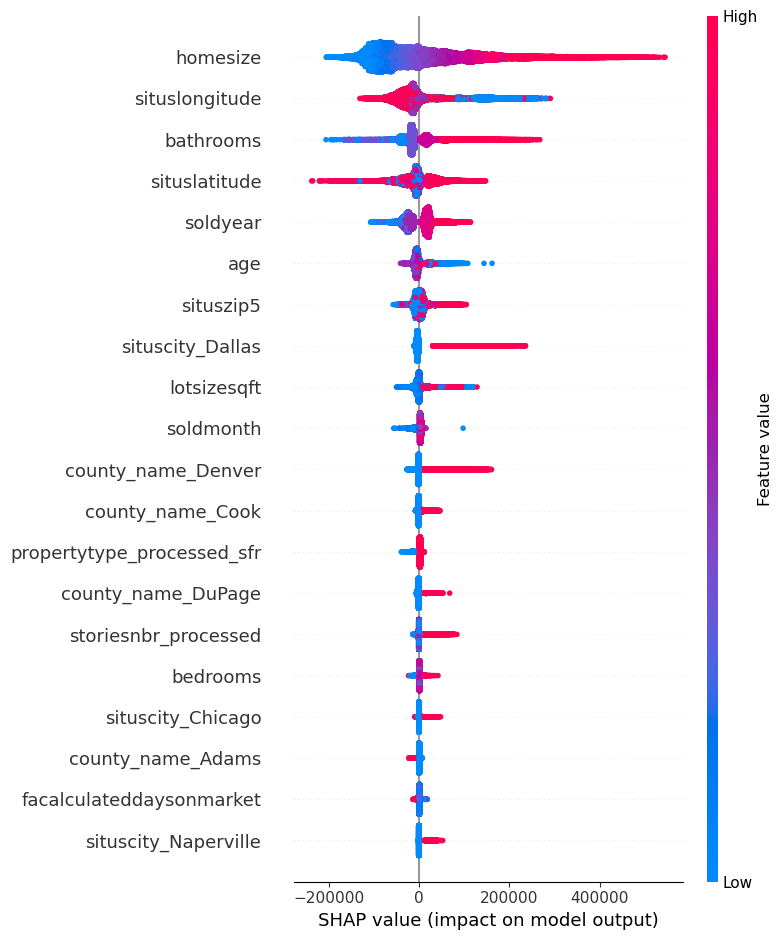

In [87]:
shap.summary_plot(shap_values, X_test_scaled_shap)

By using Shap value we can see features importance contributing to our model:
To interpret the graph: Feature value on the right shows low to high value by color. Red color means for high observations
Shap value: High shap value means high contribution to model. Remember to use color to see the relation of feature value and positive/negative impact
1. Homesize: High value means high value for target
2. situslongitude: the lower the value of longitude, the higher the house price
3. bathrooms: More bathrooms means higher house price
4. soldyear: the more recent sold year, the higher the price
5. age: new built house, higher price
6. zip5: 
7. city_dalas: if it is dallas, the house price is high
8. and so on


# CATBOOST

In [263]:
import catboost as cb
from catboost import Pool
manual_params = {'bagging_temperature': 1, 'depth': 9, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
catboost = cb.CatBoostRegressor(iterations=4000, **manual_params, loss_function='RMSE')
catboost.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), verbose=False)

Catboost took me 5m33s to fit

In [265]:
y_train_pred = catboost.predict(X_train_scaled)
y_test_pred = catboost.predict(X_test_scaled)
    
mse_train = mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))
mse_test = mean_squared_error(np.expm1(y_test), np.expm1(y_test_pred))

r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

In [266]:
print('RMSE train: ', np.sqrt(mse_train))
print('R2 train: ', r2_train )
print('RMSE test: ', np.sqrt(mse_test))
print('R2 test: ', r2_test )
print('normalize RMSE on test: ', np.sqrt(mse_test) /price_range )

RMSE train:  65549.11605036209
R2 train:  0.9090876713428232
RMSE test:  82571.88519303566
R2 test:  0.8676417639245744
normalize RMSE on test:  0.05304119813267105


Catboost train faster and gain better score than XGBOOST
